In [1]:
import numpy as np
import astropy
from astropy.table import Table, Column,join,vstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os
from glob import glob
from shutil import copyfile
from pymoc import MOC
from pymoc.util import catalog
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import KernelDensity

In [5]:
from mltier import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma_all, get_q_m, get_threshold, q0_min_level, q0_min_numbers,
                     get_n_m_kde, estimate_q_m_kde, get_q_m_kde, describe)
from Q0_calc import Q0_calc

#### Read in the optical and infrared data and the radio data

In [7]:
opt_ir_cat = Table.read('/its/home/im281/HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')

In [13]:
#lofar_all = Table.read('/its/home/im281/HELP/dmu_products/dmu8/data/data/deep-lockman-v0.1.cat.fits')
lofar_all = Table.read('/its/home/im281/FIR-group/Ian/lofar/deep_fields/Lockman/data/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.fits')

In [14]:
opt_colname = 'm_megacam_r'
ir_colname = 'm_irac_i2'

#### Define the field 

In [15]:
#select the moc of the optical data
#MOC_loc = 'mocs/DF-SWIRE_Lockman-SWIRE_MOC.fits'
#MHz150_MOC1 = MOC(filename=MOC_loc)
MOC_loc = '/its/home/im281/HELP/dmu_products/dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_Lockman-SWIRE_MOC.fits'
MHz150_MOC = MOC(filename=MOC_loc)
#MHz150_MOC = MHz150_MOC1 - MHz150_MOC2

In [16]:
ra_down, ra_up, dec_down, dec_up = min(lofar_all['RA']),max(lofar_all['RA']),min(lofar_all['DEC']),max(lofar_all['DEC'])
field = Field(ra_down, ra_up, dec_down, dec_up, MHz150_MOC)

field area is defined by a MOC


#### Filter the catalogues

In [19]:
# remove sources with a major axis greater than 30 arcseconds
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 15.)], 
                               colnames=("RA", "DEC"))

filtering in a MOC


In [18]:
opt_ir = field.filter_catalogue(opt_ir_cat, 
                               colnames=("ra", "dec"))
#remove sources with no detection in the opt or ir bands used for xmatching
mask = (~np.isnan(opt_ir[opt_colname])) | (~np.isnan(opt_ir[ir_colname]))
opt_ir = opt_ir[mask]

filtering in a MOC


In [20]:
opt_ir["colour"] = opt_ir[opt_colname] - opt_ir[ir_colname]

In [21]:
opt_ir_index = np.arange(len(opt_ir))

In [22]:
opt_ir_coords = SkyCoord(opt_ir['ra'], 
                           opt_ir['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [23]:
lofar_coords = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

In [24]:
print('number of radio sources within SWIRE footprint is: {}'.format(len(lofar)))
print('number of lofar sources iwth major axis>45" is: {}'.format(np.sum(lofar['Maj']*3600>45)))

number of radio sources within SWIRE footprint is: 19346
number of lofar sources iwth major axis>45" is: 30


In [25]:
idx_radio, idx_radiox, _, _ = search_around_sky(
            lofar_coords, lofar_coords, 45*u.arcsec)

In [26]:
idx,counts = np.unique(idx_radio,return_counts=True)
print('number of clustered sources (>4 sources within 45") is : {}'.format(np.sum(counts>3)))

number of clustered sources (>4 sources within 45") is : 4278


In [27]:
np.sum(lofar[counts>3]['S_Code']=='M')

1005

In [28]:
lofar[0]

Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code
,,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,Jy / beam,Jy / beam,
int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1
3962,4066,165.188170438,0.000296172956493,57.4468294332,0.000195501421197,0.00165142036634,0.000365843762868,0.000553041865774,9.38822880634e-05,165.188170438,0.000296172956493,57.4468294332,0.000195501421197,0.00391250464344,0.000776738402454,0.00212124831163,0.000307909411134,64.3000338474,19.5573452814,0.00391034037329,0.000776738402454,0.00212120462089,0.000307909411134,61.4023176131,19.5573452814,0.00353932749292,0.000776738402454,0.00131217460425,0.000307909411134,64.3000338474,19.5573452814,0.00353736965232,0.000776738402454,0.00131214757779,0.000307909411134,61.4023176131,19.5573452814,0.00109847518893,0.000168187651034,9.323139966e-05,0.0,6.91451932653e-05,2.13903354052e-06,S


In [29]:
opt_ir_num_both = (~np.isnan(opt_ir[opt_colname]) & ~np.isnan(opt_ir[ir_colname])) # number of sources detected in opt and ir
opt_ir_num_opt = (~np.isnan(opt_ir[opt_colname]) & np.isnan(opt_ir[ir_colname])) # number of sources detected in opt only
opt_ir_num_ir =(np.isnan(opt_ir[opt_colname]) & ~np.isnan(opt_ir[ir_colname])) # number of sources detected in ir only
opt_num = opt_ir_num_both | opt_ir_num_opt
ir_num = opt_ir_num_both | opt_ir_num_ir

opt_cat = opt_ir[opt_num]
ir_cat = opt_ir[ir_num]

In [30]:
print("Total    - ", len(opt_ir))
print("opt and ir - ", np.sum(opt_ir_num_both))
print("Only opt   - ", np.sum(opt_ir_num_opt))
print("With opt   - ", np.sum(opt_num))
print("Only ir  - ", np.sum(opt_ir_num_ir))
print("With ir  - ", np.sum(ir_num))

Total    -  1483392
opt and ir -  446792
Only opt   -  711790
With opt   -  1158582
Only ir  -  324810
With ir  -  771602


check the distribution of sources to make sure the selected area is correct and that there are no gaps that could influence the calculation of Q0

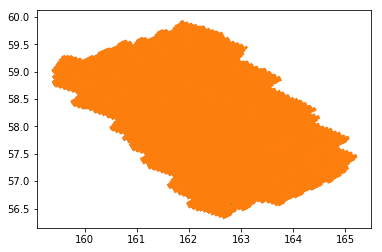

In [31]:
x = lofar['RA']
y = lofar['DEC']
plt.scatter(x,y,s=0.1)

x = opt_ir['ra']
y = opt_ir['dec']
plt.scatter(x,y,s=0.01)
plt.show()

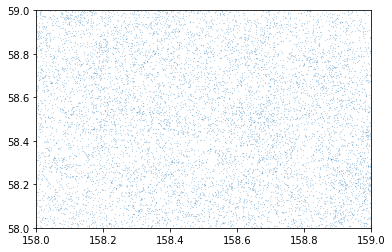

In [32]:
mask = ~np.isnan(opt_ir_cat['m_gpc1_i'])
x = opt_ir_cat['ra'][mask]
y = opt_ir_cat['dec'][mask]
plt.scatter(x,y,s=0.01)
plt.xlim(158,159)
plt.ylim(58,59)
plt.show()

### Compute Q0 for the optical and IR

In [33]:
Q0_opt,search_rad_r = Q0_calc(lofar,opt_cat,'RA','DEC','ra','dec',opt_colname,min(lofar['RA']),max(lofar['RA']),min(lofar['DEC']),max(lofar['DEC']),0.1,8,30,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
[    0     1     2 ..., 19343 19344 19345]
7418
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
number of random sources with no matches: 7415
number of real sources with no matches: 7272
number of random sources with no matches: 7413
number of real sources with no matches: 7272
number of random sources with no matches: 7415
number of real sources with no matches: 7272
number of random sources with no matches: 7414
number of real sources with no matches: 7272
number of random sources with no matches: 7413
number of real sources with no matches: 7272
number of random sources with no matches: 7417
number of real sources with no matches: 7272
number of random sources with no matches: 7415
number of real sources with no matches: 7272
number of random sources with no matches: 7416
number of real sources with no matches: 7272
number of random sources with no matches: 7411
number of real s

number of random sources with no matches: 5877
number of real sources with no matches: 1663
number of random sources with no matches: 5891
number of real sources with no matches: 1663
number of random sources with no matches: 5815
number of real sources with no matches: 1663
number of random sources with no matches: 5821
number of real sources with no matches: 1663
number of random sources with no matches: 5828
number of real sources with no matches: 1663
number of random sources with no matches: 5819
number of real sources with no matches: 1663
number of random sources with no matches: 5782
number of real sources with no matches: 1663
finding Q0 with radius = 2.5517241379310343 arcseconds
number of random sources with no matches: 5487
number of real sources with no matches: 1514
number of random sources with no matches: 5574
number of real sources with no matches: 1514
number of random sources with no matches: 5533
number of real sources with no matches: 1514
number of random sources 

number of random sources with no matches: 3061
number of real sources with no matches:  820
number of random sources with no matches: 3029
number of real sources with no matches:  820
finding Q0 with radius = 4.73103448275862 arcseconds
number of random sources with no matches: 2767
number of real sources with no matches:  746
number of random sources with no matches: 2795
number of real sources with no matches:  746
number of random sources with no matches: 2791
number of real sources with no matches:  746
number of random sources with no matches: 2830
number of real sources with no matches:  746
number of random sources with no matches: 2775
number of real sources with no matches:  746
number of random sources with no matches: 2785
number of real sources with no matches:  746
number of random sources with no matches: 2770
number of real sources with no matches:  746
number of random sources with no matches: 2858
number of real sources with no matches:  746
number of random sources wi

number of random sources with no matches: 1047
number of real sources with no matches:  282
number of random sources with no matches: 1058
number of real sources with no matches:  282
number of random sources with no matches: 1058
number of real sources with no matches:  282
number of random sources with no matches: 1014
number of real sources with no matches:  282
number of random sources with no matches: 1021
number of real sources with no matches:  282
number of random sources with no matches: 1088
number of real sources with no matches:  282
number of random sources with no matches: 1082
number of real sources with no matches:  282
number of random sources with no matches: 1019
number of real sources with no matches:  282
finding Q0 with radius = 7.182758620689654 arcseconds
number of random sources with no matches:  982
number of real sources with no matches:  249
number of random sources with no matches:  912
number of real sources with no matches:  249
number of random sources w

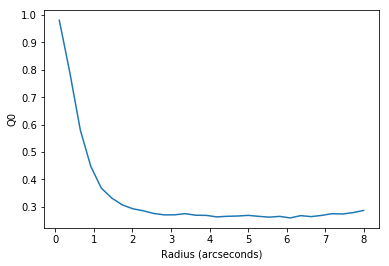

Q0 = 0.7407243011867102
search radius = 6.093103448275862


In [34]:
x = search_rad_r
y = 1 - np.array(Q0_opt)
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()

Q0 = max(Q0_opt)
search_rad_opt = search_rad_r[Q0_opt == Q0][0]
#Q0 = popt[0]
#search_rad = 6.9103

print('Q0 = {}'.format(Q0))
print('search radius = {}'.format(search_rad_opt))
Q0_opt = Q0

In [35]:
Q0_ir,search_rad_r = Q0_calc(lofar,ir_cat,'RA','DEC','ra','dec',ir_colname,min(lofar['RA']),max(lofar['RA']),min(lofar['DEC']),max(lofar['DEC']),0.1,8,30,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
[    0     1     2 ..., 19343 19344 19345]
7418
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
number of random sources with no matches: 7417
number of real sources with no matches: 7230
number of random sources with no matches: 7417
number of real sources with no matches: 7230
number of random sources with no matches: 7413
number of real sources with no matches: 7230
number of random sources with no matches: 7417
number of real sources with no matches: 7230
number of random sources with no matches: 7414
number of real sources with no matches: 7230
number of random sources with no matches: 7417
number of real sources with no matches: 7230
number of random sources with no matches: 7414
number of real sources with no matches: 7230
number of random sources with no matches: 7416
number of real sources with no matches: 7230
number of random sources with no matches: 7415
number of real s

number of random sources with no matches: 6291
number of real sources with no matches:  300
number of random sources with no matches: 6218
number of real sources with no matches:  300
number of random sources with no matches: 6279
number of real sources with no matches:  300
number of random sources with no matches: 6264
number of real sources with no matches:  300
number of random sources with no matches: 6257
number of real sources with no matches:  300
number of random sources with no matches: 6247
number of real sources with no matches:  300
number of random sources with no matches: 6224
number of real sources with no matches:  300
finding Q0 with radius = 2.5517241379310343 arcseconds
number of random sources with no matches: 5979
number of real sources with no matches:  242
number of random sources with no matches: 5913
number of real sources with no matches:  242
number of random sources with no matches: 5960
number of real sources with no matches:  242
number of random sources 

number of random sources with no matches: 3823
number of real sources with no matches:  138
number of random sources with no matches: 3833
number of real sources with no matches:  138
finding Q0 with radius = 4.73103448275862 arcseconds
number of random sources with no matches: 3482
number of real sources with no matches:  136
number of random sources with no matches: 3612
number of real sources with no matches:  136
number of random sources with no matches: 3542
number of real sources with no matches:  136
number of random sources with no matches: 3575
number of real sources with no matches:  136
number of random sources with no matches: 3527
number of real sources with no matches:  136
number of random sources with no matches: 3540
number of real sources with no matches:  136
number of random sources with no matches: 3506
number of real sources with no matches:  136
number of random sources with no matches: 3535
number of real sources with no matches:  136
number of random sources wi

number of random sources with no matches: 1684
number of real sources with no matches:  100
number of random sources with no matches: 1707
number of real sources with no matches:  100
number of random sources with no matches: 1626
number of real sources with no matches:  100
number of random sources with no matches: 1643
number of real sources with no matches:  100
number of random sources with no matches: 1763
number of real sources with no matches:  100
number of random sources with no matches: 1765
number of real sources with no matches:  100
number of random sources with no matches: 1689
number of real sources with no matches:  100
number of random sources with no matches: 1675
number of real sources with no matches:  100
finding Q0 with radius = 7.182758620689654 arcseconds
number of random sources with no matches: 1551
number of real sources with no matches:   95
number of random sources with no matches: 1545
number of real sources with no matches:   95
number of random sources w

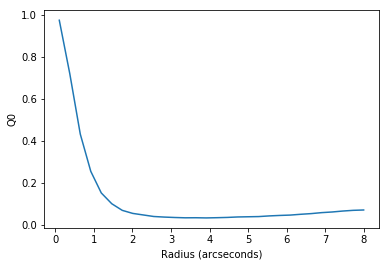

Q0 = 0.9661892885812756
search radius = 3.913793103448276


In [36]:
x = search_rad_r
y = 1 - np.array(Q0_ir)
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()
Q0 = max(Q0_ir)

search_rad_ir = search_rad_r[Q0_ir == Q0][0]
#Q0 = popt[0]
#search_rad = 6.9103

print('Q0 = {}'.format(Q0))
print('search radius = {}'.format(search_rad_ir))
Q0_ir = Q0

### Prepare the optical likelihood ratio

In [41]:
opt_cat = opt_ir[opt_num]

In [42]:
bin_list_opt = np.arange(7., 35., 0.05)
center_opt = get_center(bin_list_opt)

In [24]:
bandwidth_opt = 0.5

#find the magnitude distribution of all sources n(m)
n_m_opt = get_n_m(opt_cat[opt_colname], bin_list_opt, field.area)
#find the magnitude distribution of all sources using a kernal instead of bining 
n_m_opt_kde = get_n_m_kde(opt_cat[opt_colname], center_opt, field.area, bandwidth=bandwidth_opt)
n_m_opt_kde_cs = np.cumsum(n_m_opt_kde)

#estimate q(m) using the method of Fleuren et al 2012
q_m_opt = estimate_q_m(opt_cat[opt_colname], 
                      bin_list_opt, 
                      n_m_opt, 
                      lofar_coords, 
                      opt_ir_coords[opt_num], 
                      radius=5)

#estimate q(m) using the method of fleuren et al 2012 but instead of binning the magnitudes using a
#kernal to create a smoother q(m)
q_m_opt_kde = estimate_q_m_kde(opt_cat[opt_colname], 
                      center_opt, 
                      n_m_opt_kde, 
                      lofar_coords, 
                      opt_ir_coords[opt_num], 
                      radius=5, 
                      bandwidth=bandwidth_opt)
q_m_opt_kde_cs = np.cumsum(q_m_opt_kde)

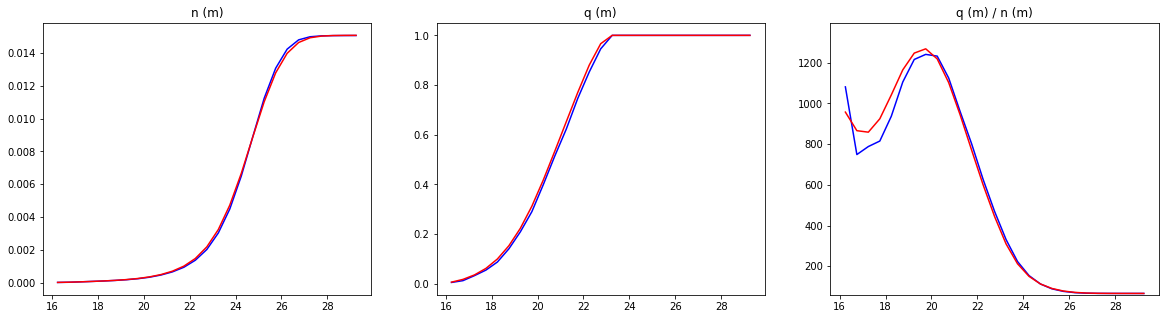

In [25]:
plt.rcParams["figure.figsize"] = (20,5)
plt.subplot(1,3,1)
plt.plot(center_opt, n_m_opt,color='blue');
plt.plot(center_opt, n_m_opt_kde_cs,color='red');
plt.title('n (m)')


plt.subplot(1,3,2)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_opt, q_m_opt,color='blue');
plt.plot(center_opt, q_m_opt_kde_cs,color='red');
plt.title('q (m)')

plt.subplot(1,3,3)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_opt, q_m_opt/n_m_opt,color='blue');
plt.plot(center_opt, q_m_opt_kde_cs/n_m_opt_kde_cs,color='red');
plt.ylim(0.9*np.min(q_m_opt_kde_cs/n_m_opt_kde_cs),1.1*np.max(q_m_opt_kde_cs/n_m_opt_kde_cs))
plt.title('q (m) / n (m)')
plt.show()

In [26]:
likelihood_ratio_opt = SingleMLEstimator(Q0_opt, n_m_opt_kde_cs, q_m_opt_kde_cs, center_opt)

### Prepare the IR likelihood ratio

In [37]:
ir_cat = opt_ir[ir_num]

In [43]:
bin_list_ir = np.arange(7., 35., 0.05)
center_ir = get_center(bin_list_ir)

In [44]:
bandwidth_ir = 0.5

n_m_ir = get_n_m(ir_cat[ir_colname], bin_list_ir, field.area)
n_m_ir_kde = get_n_m_kde(ir_cat[ir_colname], center_ir, field.area, bandwidth=bandwidth_ir)
n_m_ir_kde_cs = np.cumsum(n_m_ir_kde)

q_m_ir = estimate_q_m(ir_cat[ir_colname], 
                      bin_list_ir, 
                      n_m_ir, 
                      lofar_coords, 
                      opt_ir_coords[ir_num], 
                      radius=5)

q_m_ir_kde = estimate_q_m_kde(ir_cat[ir_colname], 
                      center_ir, 
                      n_m_ir_kde, 
                      lofar_coords, 
                      opt_ir_coords[ir_num], 
                      radius=5, 
                      bandwidth=bandwidth_ir)
q_m_ir_kde_cs = np.cumsum(q_m_ir_kde)

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


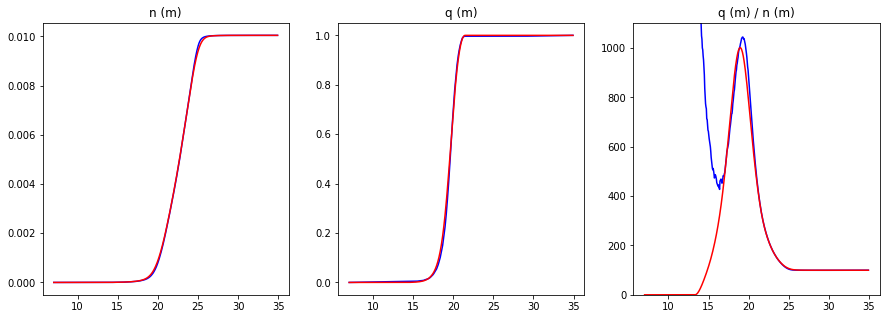

In [45]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.plot(center_ir, n_m_ir,color='blue');
plt.plot(center_ir, n_m_ir_kde_cs,color='red');
plt.title('n (m)')

plt.subplot(1,3,2)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_ir, q_m_ir,color='blue');
plt.plot(center_ir, q_m_ir_kde_cs,color='red');
plt.title('q (m)')

plt.subplot(1,3,3)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_ir, q_m_ir/n_m_ir,color='blue');
plt.plot(center_ir, q_m_ir_kde_cs/n_m_ir_kde_cs,color='red');
plt.ylim(0.9*np.min(q_m_ir_kde_cs/n_m_ir_kde_cs),1.1*np.max(q_m_ir_kde_cs/n_m_ir_kde_cs))
plt.title('q (m) / n (m)')
plt.show()

In [46]:
ir_param_list = [n_m_ir,q_m_ir,q_m_ir_kde]
pickle.dump(ir_param_list,open('LR_params_I2.pkl','wb'))

In [31]:
likelihood_ratio_ir = SingleMLEstimator(Q0_ir, n_m_ir_kde_cs, q_m_ir_kde_cs, center_ir)

### Start the magnitude only crossmatch

#### optical

In [32]:
import multiprocessing
n_cpus_total = multiprocessing.cpu_count()
n_cpus = max(1, n_cpus_total-1)

In [33]:
radius = 15
idx_lofar, idx_opt, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[opt_num], radius*u.arcsec)

# create an array of the indexs of lofar sources with a possible crossmatch within the search radius
idx_lofar_unique = np.unique(idx_lofar)
print('number of LOFAR sources with a possible crossmatch within {} arcseconds is {}'.format(radius,len(idx_lofar_unique)))

number of LOFAR sources with a possible crossmatch within 15 arcseconds is 11621


In [34]:
lofar["lr_opt"] = np.nan                   # Likelihood ratio
lofar["lr_dist_opt"] = np.nan              # Distance to the selected source
lofar["lr_index_opt"] = np.nan             # Index of the PanSTARRS source in combined
lofar["lr_reliability_opt"] = np.nan
lofar["helpid_opt"] = ''

In [59]:
#do the crossmatching for the radio to optical dataset
#inputs: i, the index saying which radio source to do the LR analysis for
def ml_opt(i):

    #get the indexes to the radio and optical catalogues from the cross match done above
    idx_0 = idx_opt[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = opt_cat[opt_colname][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = opt_cat["ra"][idx_0]
    c_dec = opt_cat["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    #calculate the positional error of the radio source based on the PA and major and minor axis
    #also includes an additional error of 0.6 arcseconds added in quadrature 
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_opt(mag, d2d_0.arcsec, sigma)
    #if the radio source has no sources within the search radius then return a row of nans
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    #calculate the realiability using the formula from smith et al 2013
    rel = lr_0/(lr_sum + (1-Q0_opt))
    helpid = opt_cat['help_id'][idx_0][0]
    #return the indexs to optical catalogue, the distance to the source, the likelihood ratio
    #and the helpid
    result = [opt_ir_index[opt_num][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    

    return(result)
    #return (result,rel[chosen_index],helpid)

In [60]:
res = parallel_process(idx_lofar_unique, ml_opt, n_jobs=n_cpus)

100%|██████████| 11.6k/11.6k [00:42<00:00, 273it/s]
100%|██████████| 11618/11618 [00:00<00:00, 321718.56it/s]


In [61]:
#add the crossmatched sources to the radio table
(lofar["lr_index_opt"][idx_lofar_unique], 
 lofar["lr_dist_opt"][idx_lofar_unique], 
 lofar["lr_opt"][idx_lofar_unique],
 lofar["lr_reliability_opt"][idx_lofar_unique],
 lofar["helpid_opt"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


In [62]:
lofar["lr_opt"][np.isnan(lofar["lr_opt"])] = 0

In [63]:
#calculate the threshold of trusted crossmatches using Q0 as the fraction of sources that have trusted crossmatches
mask = (~np.isnan(lofar['lr_dist_opt'])) & (lofar['lr_opt']>0)
threshold_opt = np.percentile(lofar["lr_opt"][mask], 100*(1 - Q0_opt))
threshold_opt

3.58457972454297

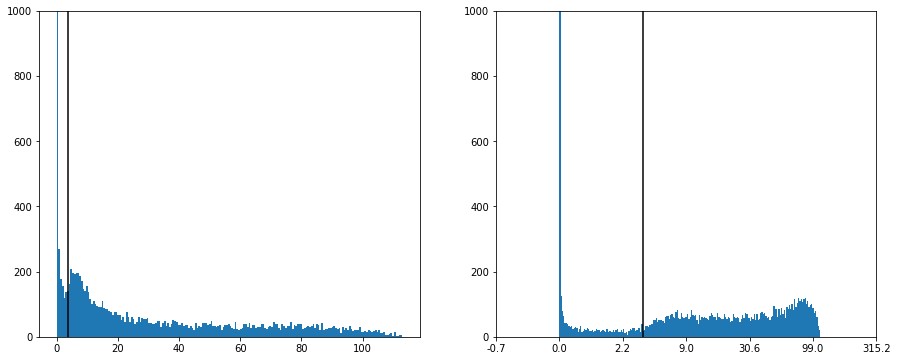

In [64]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_opt"] != 0]["lr_opt"], bins=200)
plt.vlines([threshold_opt], 0, 1000)
plt.ylim([0,1000])

plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_opt"] != 0]["lr_opt"]+1), bins=200)
plt.vlines(np.log10(threshold_opt+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);
plt.show()

In [65]:
lofar["lr_index_sel_opt"] = lofar["lr_index_opt"]
lofar["lr_index_sel_opt"][lofar["lr_opt"] < threshold_opt] = np.nan
print('number of xmatches above the threshold is {}'.format(np.sum(lofar['lr_opt']>threshold_opt)))

number of xmatches above the threshold is 8959


/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


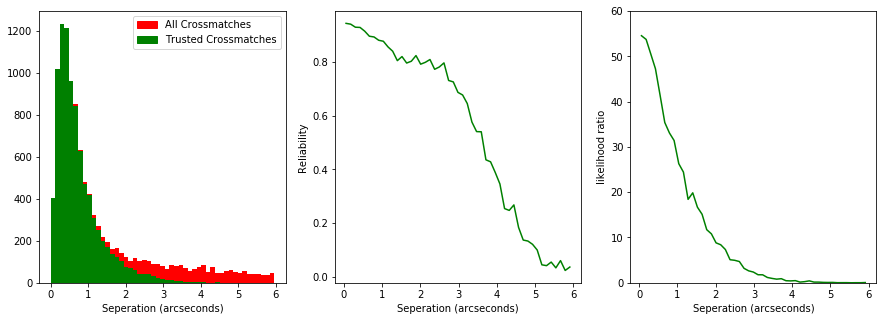

In [66]:
plt.rcParams["figure.figsize"] = (15,5)
bins = np.arange(0,search_rad_opt,search_rad_opt/50)
plt.subplot(1,3,1)
mask = ~np.isnan(lofar['lr_dist_opt'])
plt.hist(lofar['lr_dist_opt'][mask],bins=bins,color='red')
mask = (lofar['lr_opt'] > threshold_opt) & (~np.isnan(lofar['lr_dist_opt']))
plt.hist(lofar['lr_dist_opt'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(lofar['lr_dist_opt']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_opt'] > bins[n]) & (lofar['lr_dist_opt'] < bins[n+1])
    mask = mask
    rel_temp = lofar['lr_reliability_opt'][mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(lofar['lr_dist_opt']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_opt'] > bins[n]) & (lofar['lr_dist_opt'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = lofar['lr_opt'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')
plt.ylim(0,np.max(lrt_r)*1.1)

plt.show()

#### IR band

In [43]:
idx_lofar, idx_ir, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[ir_num], radius*u.arcsec)

idx_lofar_unique = np.unique(idx_lofar)
print('number of LOFAR sources with a possible crossmatch within {} arcseconds is {}'.format(radius,len(idx_lofar_unique)))

number of LOFAR sources with a possible crossmatch within 15 arcseconds is 11564


In [44]:
len(opt_ir_coords[ir_num])

733913

In [45]:
max(idx_ir)

733908

In [46]:
radius = 15
idx_lofar, idx_ir, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[ir_num], radius*u.arcsec)

# create an array of the indexs of lofar sources with a possible crossmatch within the search radius
idx_lofar_unique = np.unique(idx_lofar)
print('number of LOFAR sources with a possible crossmatch within {} arcseconds is {}'.format(radius,len(idx_lofar_unique)))

number of LOFAR sources with a possible crossmatch within 15 arcseconds is 11564


In [47]:
lofar["lr_ir"] = np.nan                   # Likelihood ratio
lofar["lr_dist_ir"] = np.nan              # Distance to the selected source
lofar["lr_index_ir"] = np.nan             # Index of the PanSTARRS source in combined
lofar["lr_reliability_ir"] = np.nan
lofar["helpid_ir"] = ''

In [48]:
def ml_ir(i):

    idx_0 = idx_ir[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = ir_cat[ir_colname][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = ir_cat["ra"][idx_0]
    c_dec = ir_cat["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_ir(mag, d2d_0.arcsec, sigma)
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_opt))
    helpid = ir_cat['help_id'][idx_0][0]
    result = [opt_ir_index[ir_num][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    

    return(result)
    #return (result,rel[chosen_index],helpid)

In [49]:
res = parallel_process(idx_lofar_unique, ml_ir, n_jobs=n_cpus)

100%|██████████| 11.6k/11.6k [00:39<00:00, 292it/s]
100%|██████████| 11561/11561 [00:00<00:00, 300381.89it/s]


In [50]:
(lofar["lr_index_ir"][idx_lofar_unique], 
 lofar["lr_dist_ir"][idx_lofar_unique], 
 lofar["lr_ir"][idx_lofar_unique],
 lofar["lr_reliability_ir"][idx_lofar_unique],
 lofar["helpid_ir"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


In [51]:
lofar["lr_ir"][np.isnan(lofar["lr_ir"])] = 0

In [52]:
mask = (~np.isnan(lofar['lr_dist_ir'])) & (lofar['lr_ir']>0)
threshold_ir = np.percentile(lofar["lr_ir"][mask], 100*(1 - Q0_ir))
threshold_ir

2.44684906615897

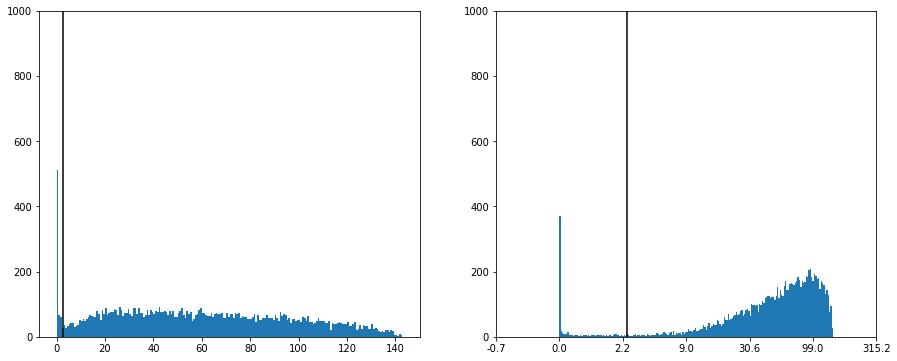

In [53]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_ir"] != 0]["lr_ir"], bins=200)
plt.vlines([threshold_ir], 0, 1000)
plt.ylim([0,1000])

plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_ir"] != 0]["lr_ir"]+1), bins=200)
plt.vlines(np.log10(threshold_ir+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);
plt.show()

In [54]:
lofar["lr_index_sel_ir"] = lofar["lr_index_ir"]
lofar["lr_index_sel_ir"][lofar["lr_ir"] < threshold_ir] = np.nan
print('number of xmatches above the threshold is {}'.format(np.sum(lofar['lr_opt']>threshold_ir)))

number of xmatches above the threshold is 9236


/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


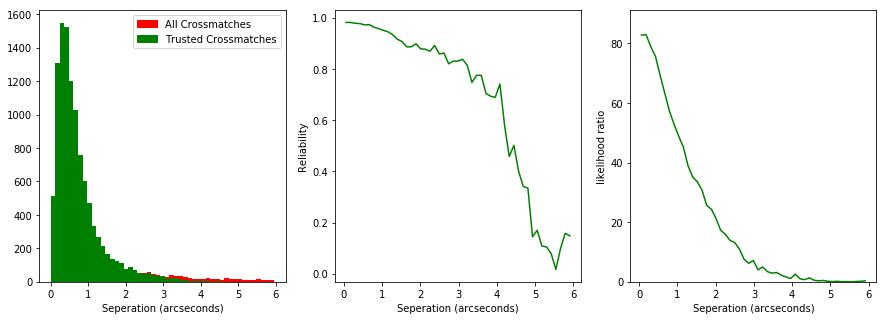

In [55]:
plt.rcParams["figure.figsize"] = (15,5)
bins = np.arange(0,search_rad_opt,search_rad_opt/50)
plt.subplot(1,3,1)
mask = ~np.isnan(lofar['lr_dist_ir'])
plt.hist(lofar['lr_dist_ir'][mask],bins=bins,color='red')
mask = (lofar['lr_ir'] > threshold_ir) & (~np.isnan(lofar['lr_dist_ir']))
plt.hist(lofar['lr_dist_ir'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(lofar['lr_dist_ir']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_ir'] > bins[n]) & (lofar['lr_dist_ir'] < bins[n+1])
    mask = mask
    rel_temp = lofar['lr_reliability_ir'][mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(lofar['lr_dist_ir']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_ir'] > bins[n]) & (lofar['lr_dist_ir'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = lofar['lr_ir'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')
plt.ylim(0,np.max(lrt_r)*1.1)

plt.show()

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [56]:
# lr_opt_and_ir = (lofar["lr_opt"] != 0) & (lofar["lr_ir"] != 0)
# lr_only_opt = (lofar["lr_opt"] != 0) & (lofar["lr_ir"] == 0)
# lr_only_ir = (lofar["lr_opt"] == 0) & (lofar["lr_ir"] != 0)
# lr_no_match = (lofar["lr_opt"] == 0) & (lofar["lr_ir"] == 0)
lr_opt_and_ir = ~np.isnan(lofar["lr_index_sel_opt"]) & ~np.isnan(lofar["lr_index_sel_ir"])
lr_only_opt = ~np.isnan(lofar["lr_index_sel_opt"]) & np.isnan(lofar["lr_index_sel_ir"])
lr_only_ir = np.isnan(lofar["lr_index_sel_opt"]) & ~np.isnan(lofar["lr_index_sel_ir"])
lr_no_match = np.isnan(lofar["lr_index_sel_opt"]) & np.isnan(lofar["lr_index_sel_ir"])

In [57]:
print(np.sum(lr_opt_and_ir))
print(np.sum(lr_only_opt))
print(np.sum(lr_only_ir))
print(np.sum(lr_no_match))

8765
186
2146
538


In [58]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [59]:
# Only i matches
lofar["lr_1"][lr_only_opt] = lofar["lr_opt"][lr_only_opt]
lofar["lr_index_1"][lr_only_opt] = lofar["lr_index_opt"][lr_only_opt]
lofar["lr_dist_1"][lr_only_opt] = lofar["lr_dist_opt"][lr_only_opt]
lofar["lr_type_1"][lr_only_opt] = 1

# Only w1 matches
lofar["lr_1"][lr_only_ir] = lofar["lr_ir"][lr_only_ir]
lofar["lr_index_1"][lr_only_ir] = lofar["lr_index_ir"][lr_only_ir]
lofar["lr_dist_1"][lr_only_ir] = lofar["lr_dist_ir"][lr_only_ir]
lofar["lr_type_1"][lr_only_ir] = 2

# Both matches
lofar["lr_1"][lr_opt_and_ir] = np.max([lofar["lr_opt"][lr_opt_and_ir], lofar["lr_ir"][lr_opt_and_ir]], axis=0)
lofar["lr_type_1"][lr_opt_and_ir] = np.argmax([lofar["lr_opt"][lr_opt_and_ir], lofar["lr_ir"][lr_opt_and_ir]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_opt_and_ir & c1] = lofar["lr_index_opt"][lr_opt_and_ir & c1]
lofar["lr_index_1"][lr_opt_and_ir & c2] = lofar["lr_index_ir"][lr_opt_and_ir & c2]
lofar["lr_dist_1"][lr_opt_and_ir & c1] = lofar["lr_dist_opt"][lr_opt_and_ir & c1]
lofar["lr_dist_1"][lr_opt_and_ir & c2] = lofar["lr_dist_ir"][lr_opt_and_ir & c2]

In [60]:
print("match    sel-opt: ", np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 1))
print("match   sel-ir: ", np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 2))
print("match   opt-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 1))
print("match  ir-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-opt:  403
match   sel-ir:  8362
match     both:  8765
match   opt-only:  186
match  ir-only:  2146
match      all:  11097
         Total:  11635


In [61]:
print('number of sources for which the match in opt-band and ir-band are above the threshold but gives a different match to the combined catalogue is {}'.format(np.sum(lofar["lr_index_opt"][lr_opt_and_ir] != lofar["lr_index_ir"][lr_opt_and_ir])))

number of sources for which the match in opt-band and ir-band are above the threshold but gives a different match to the combined catalogue is 1045


### Define the colour bins to be used later

Create color bins in the opt-ir plane.

In [62]:
colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [63]:
# start with the only opt or ir detected and the colour < lowest colour bin 
colour_bin_def = [{"name":"only W1", "condition": opt_ir_num_ir},
                  {"name":"only i", "condition": opt_ir_num_opt},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (opt_ir["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((opt_ir["colour"] >= colour_limits[i]) & 
                 (opt_ir["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (opt_ir["colour"] >= colour_limits[-1])})

/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [64]:
# assign every source a number based on which colour bin it is in
opt_ir["category"] = np.nan
for i in range(len(colour_bin_def)):
    opt_ir["category"][colour_bin_def[i]["condition"]] = i

In [65]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])
numbers_combined_bins

array([237371, 662040,  30068,  34848,  56371,  37158,  41589,  42615,
        40476,  36416,  31998,  27124,  22618,  35954,  25546,  33761])

## Skipped bit on duplicated sources

In [66]:
bin_list = [bin_list_ir if i == 0 else bin_list_opt for i in range(len(colour_bin_def))]
centers = [center_ir if i == 0 else center_opt for i in range(len(colour_bin_def))]

numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])
bandwidth_colour = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
numbers_combined_bins

array([237371, 662040,  30068,  34848,  56371,  37158,  41589,  42615,
        40476,  36416,  31998,  27124,  22618,  35954,  25546,  33761])

In [67]:
#Calculate n(m) and q(m) within each colour bin to give n(m,c) and q(m,c)
n_m_kde = []

# W1 only sources
n_m_kde.append(get_n_m_kde(opt_ir[ir_colname][opt_ir["category"] == 0], 
                       centers[0], field.area, bandwidth=bandwidth_colour[0]))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m_kde.append(get_n_m_kde(opt_ir[opt_colname][opt_ir["category"] == i], 
                           centers[i], field.area, bandwidth=bandwidth_colour[i]))

In [68]:
n_m = []

# W1 only sources
n_m.append(get_n_m(opt_ir[ir_colname][opt_ir["category"] == 0], bin_list_ir, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m(opt_ir[opt_colname][opt_ir["category"] == i], bin_list_opt, field.area))

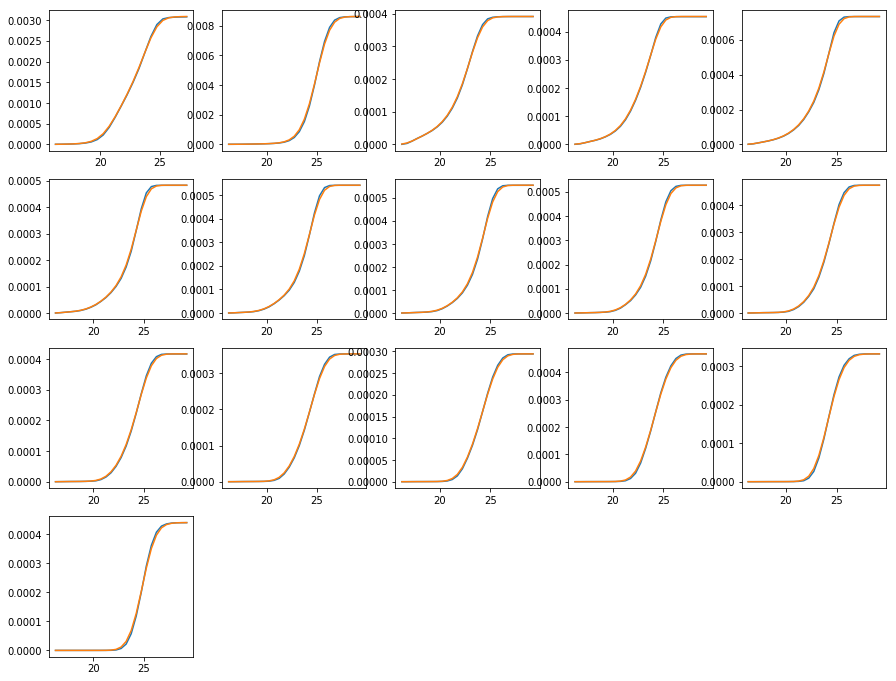

In [69]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m_kde):
    plt.subplot(5,5,i+1)
    plt.plot(centers[i], n_m[i])
    plt.plot(centers[i], np.cumsum(n_m_k))
plt.show()

In [70]:
lofar["category"] = np.nan
lofar[ir_colname] = np.nan
lofar[opt_colname] = np.nan

In [71]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = opt_ir[indices]["category"]
lofar[ir_colname][c] = opt_ir[indices][ir_colname]
lofar[opt_colname][c] = opt_ir[indices][opt_colname]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [72]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([2625,  273,   31,  224,  621,  375,  406,  421,  392,  410,  404,
        464,  494, 1020, 1022, 1915])

In [73]:
#Q0(c) is defined as the fraction of trsuted crossmatches in each category to give a value of Q0 in each category
#and Q0(c) is the sum of these individual Q0's divided by the total number of radio sources
Q_0_colour = numbers_lofar_combined_bins/len(lofar)
q0_total = np.sum(Q_0_colour)
q0_total

0.9537602062741727

In [74]:
#calculate q(m) in each colour bin to calculate q(m,c)
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m(lofar[ir_colname][lofar["category"] == 0], 
                   bin_list_ir, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m(lofar[opt_colname][lofar["category"] == i], 
                   bin_list_opt, 
                   numbers_lofar_combined_bins[i], 
                   n_m[i], 
                   field.area, 
                   radius=radius))

In [75]:
q_m_kde = []
radius = 15. 

# W1 only sources
q_m_kde.append(get_q_m_kde(lofar[ir_colname][lofar["category"] == 0], 
                   centers[0], 
                   radius=radius,
                   bandwidth=0.5))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m_kde.append(get_q_m_kde(lofar[opt_colname][lofar["category"] == i], 
                   centers[i], 
                   radius=radius,
                   bandwidth=bandwidth_colour[i]))

In [76]:
np.ones_like(23)
centers[0]

array([16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25,
       20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25, 24.75,
       25.25, 25.75, 26.25, 26.75, 27.25])

In [77]:
np.ones_like(centers[0])*0.5

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

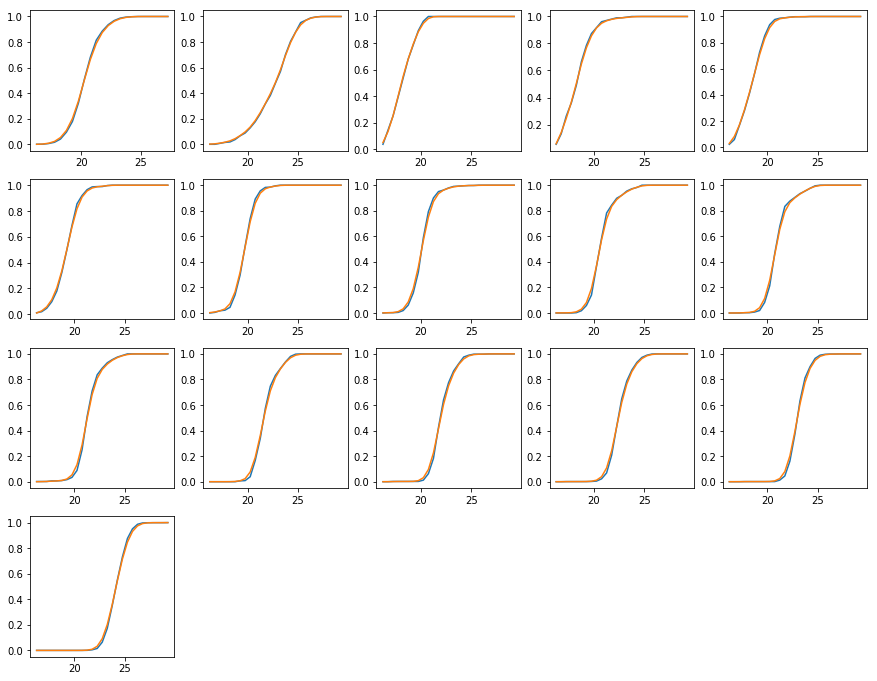

In [78]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m_kde):
    plt.subplot(5,5,i+1)
    plt.plot(centers[i], q_m[i])
    plt.plot(centers[i], np.cumsum(q_m_k))
plt.show()

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


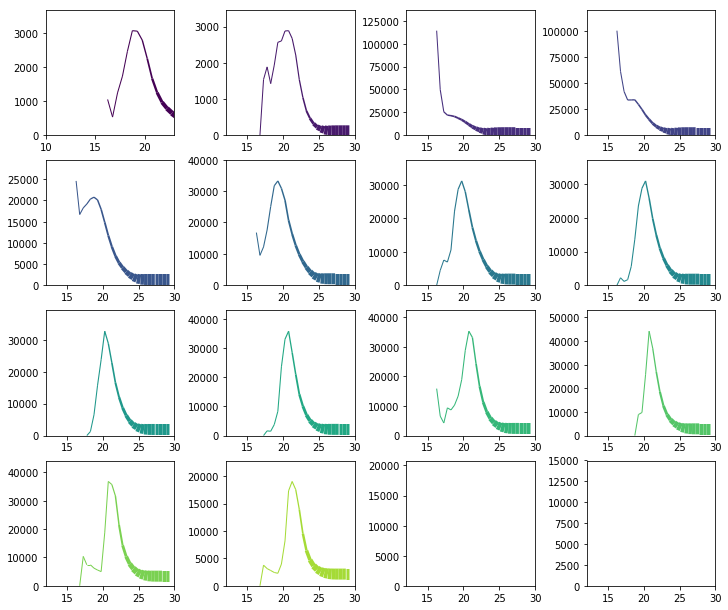

In [79]:
#plot q(m,c)/n(m,c) to see that everthing looks okay. The width of the line shows how many sources are in the bin
plt.rcParams["figure.figsize"] = (12,10)

from matplotlib import cm
from matplotlib.collections import LineCollection

cm_subsection = np.linspace(0., 1., 16) 
colors = [ cm.viridis(x) for x in cm_subsection ]

low = np.nonzero(centers[1] >= 15)[0][0]
high = np.nonzero(centers[1] >= 22.2)[0][0]

fig, a = plt.subplots()

for i, q_m_k in enumerate(q_m):
    #plot(centers[i], q_m_old[i]/n_m_old[i])
    a = plt.subplot(4,4,i+1)
    if i not in [-1]:
        n_m_aux = n_m[i]/np.sum(n_m[i])
        lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
        #print(lwidths)
        
        y_aux = q_m_k/n_m[i]
        mask = ~np.isnan(y_aux)
        y_aux = y_aux[mask]
        factor = np.max(y_aux[low:high])
        y = y_aux
        #print(y)
        x = centers[i]
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, linewidths=lwidths, color=colors[i])
        
        a.add_collection(lc)
        
        #plot(centers[i], x/factor, color=colors[i-1])
        plt.xlim([12, 30])
        if i == 0:
            plt.xlim([10, 23])
        plt.ylim([0, 1.2*factor])

plt.subplots_adjust(left=0.125, 
                bottom=0.1, 
                right=0.9, 
                top=0.9,
                wspace=0.4, 
                hspace=0.2)
plt.show()

In [80]:
selection = ~np.isnan(opt_ir["category"]) # Avoid the two dreaded sources with no actual data
catalogue = opt_ir[selection]

In [81]:
radius = 15

In [82]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue[opt_colname][idx_0]
    mag[category == 0] = catalogue[ir_colname][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    if len(lr_0) == 0:

        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-q0_total))
    helpid = catalogue['help_id'][idx_0][0]
    result = [opt_ir_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [83]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[selection], radius*u.arcsec)
idx_lofar_unique = np.unique(idx_lofar)

In [84]:
likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m_kde, q_m_kde, centers)

In [85]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [86]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 11.6k/11.6k [00:56<00:00, 204it/s] 
100%|██████████| 11626/11626 [00:00<00:00, 255848.74it/s]


In [87]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan
lofar["lr_reliability_2"] = np.nan
lofar["helpid_2"] = ''

In [88]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique],
 lofar["lr_reliability_2"][idx_lofar_unique],
 lofar["helpid_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


In [89]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

mask = (~np.isnan(lofar["lr_dist_2"])) & (lofar['lr_2']>0)
threshold = np.percentile(lofar["lr_2"][mask], 100*(1 - q0_total))
threshold

0.2664323871537029

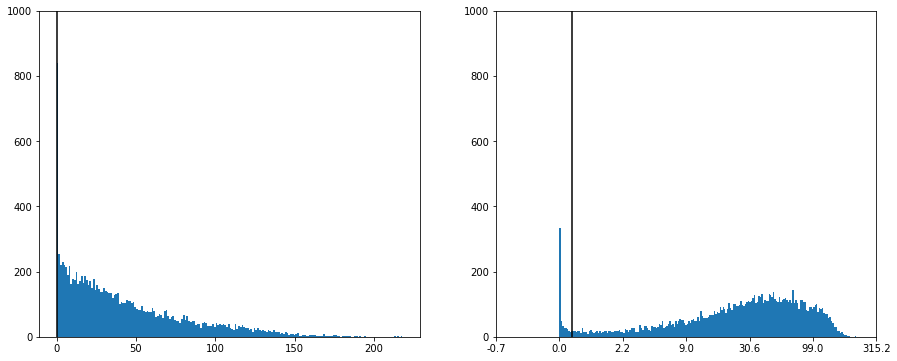

In [90]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
plt.vlines([threshold], 0, 1000)
plt.ylim([0,1000])
plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
plt.vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);
plt.show()

In [91]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [92]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))
n_changes

248

In [93]:
lofar["category"] = np.nan
lofar[ir_colname] = np.nan
lofar[opt_colname] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = opt_ir[indices]["category"]
lofar[ir_colname][c] = opt_ir[indices][ir_colname]
lofar[opt_colname][c] = opt_ir[indices][opt_colname]

In [94]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([2700,   90,   26,  222,  618,  375,  417,  423,  391,  415,  408,
        470,  501, 1039, 1044, 1952])

## Skipped rerun iter section

In [95]:
def plot_q_n_m(q_m, n_m):
    fig, a = plt.subplots()

    for i, q_m_k in enumerate(q_m):
        #plot(centers[i], q_m_old[i]/n_m_old[i])
        a = plt.subplot(4,4,i+1)
        if i not in [-1]:
            n_m_aux = n_m[i]/np.sum(n_m[i])
            lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
            #print(lwidths)

            y_aux = q_m_k/n_m[i]
            
            y = y_aux
            mask = ~np.isnan(y_aux)
            y_aux = y_aux[mask]
            factor = np.max(y_aux[low:high])
            #print(y)
            x = centers[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, linewidths=lwidths, color=colors[i])

            a.add_collection(lc)

            #plot(centers[i], x/factor, color=colors[i-1])
            plt.xlim([12, 30])
            if i == 0:
                plt.xlim([10,23])
            plt.ylim([0, 1.2*factor])

    plt.subplots_adjust(left=0.125, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.2)
    return fig

In [96]:
#create a copy of the radio catalogue for debugging
original = lofar.copy()

In [97]:
lofar = original.copy()

In [98]:
#Calculate the LR for radio sources using color
#returns the reliability and other parameters for each potential crossmatch to allow comparison
#the column lr_max is set to true for the crossmatch with the highest LR for each radio source

#the column lr_sel is set to true for the crossmatch with the highest LR for each radio source 
#but will later be set to false if the LR is below the threshold

def apply_ml_all(i, likelihood_ratio_function):
    
    #print(i)
    
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    if len(idx_0) == 0:
        print('no sources within search radius')
        temp = Table()
        col_index = Column(np.nan,name='lr_index_{}'.format(iteration))
        col_d2d = Column(np.nan,name='lr_dist_{}'.format(iteration))
        col_lr = Column(np.nan,name='lr_{}'.format(iteration))
        col_rel = Column(np.nan,name='lr_reliability_{}'.format(iteration))
        col_sourceid = Column(np.nan,name='Source_id')
        col_helpid = Column('',name='help_id')
        col_lr_max = Column(False,name='lr_max_{}'.format(iteration))
        col_lr_sel = Column(False,name='lr_sel_{}'.format(iteration))
        temp.add_columns([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid,col_lr_max,col_lr_sel])
        return temp,0
    
    if j>0:
        s_id = source_ids[i]
        mask = (lofar['Source_id'] == s_id)
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue[opt_colname][idx_0]
    mag[category == 0] = catalogue[ir_colname][idx_0][category == 0]
    #print(mag)
    
    if j>0:
        lofar_ra = original[i]["RA"]
        lofar_dec = original[i]["DEC"]
        lofar_pa = original[i]["PA"]
        lofar_maj_err = original[i]["E_Maj"]
        lofar_min_err = original[i]["E_Min"]
        
    else:
        lofar_ra = lofar[i]["RA"]
        lofar_dec = lofar[i]["DEC"]
        lofar_pa = lofar[i]["PA"]
        lofar_maj_err = lofar[i]["E_Maj"]
        lofar_min_err = lofar[i]["E_Min"]
        
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    #print(lr_0)

    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-q0_total))
    helpid = catalogue['help_id'][idx_0]
    sourceid = (np.zeros(len(lr_0)) + np.unique(lofar['Source_id'])[i]).astype('int')
    col_index = Column(opt_ir_index[selection][idx_0],name='lr_index_{}'.format(iteration))
    col_d2d = Column(d2d_0.arcsec,name='lr_dist_{}'.format(iteration))
    col_lr = Column(lr_0,name='lr_{}'.format(iteration))
    col_rel = Column(rel,name='lr_reliability_{}'.format(iteration))
    col_sourceid = Column(sourceid,name='Source_id')
    col_helpid = Column(helpid,name='help_id')
    col_lr_max = Column(np.zeros(len(lr_0),dtype=bool),name='lr_max_{}'.format(iteration))
    col_lr_max[chosen_index] = True
    col_lr_sel = Column(np.zeros(len(lr_0),dtype=bool),name='lr_sel_{}'.format(iteration))
    col_lr_sel[chosen_index] = True

    #print(col_sourceid)
    #print(col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid)
    
    temp = Table([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid,col_lr_max,col_lr_sel])

    lrs = np.max(col_lr)
    
    #if np.sum(col_lr_max)!=1:
    #    print('problem')
    #    print(temp)
    return (temp,lrs)

    #return (result)

Iteration 3
numbers_lofar_combined_bins
[2700   90   26  222  618  375  417  423  391  415  408  470  501 1039
 1044 1952]
Q_0_colour
[0.23205844 0.00773528 0.00223464 0.01908036 0.0531156  0.03223034
 0.03584014 0.03635582 0.0336055  0.03566824 0.03506661 0.04039536
 0.04305973 0.08929953 0.08972927 0.16776966]
Q_0_total:  0.9532445208422862


100%|██████████| 11.6k/11.6k [01:07<00:00, 173it/s] 
100%|██████████| 11626/11626 [00:00<00:00, 289240.04it/s]


Threshold:  0.18319611862368892


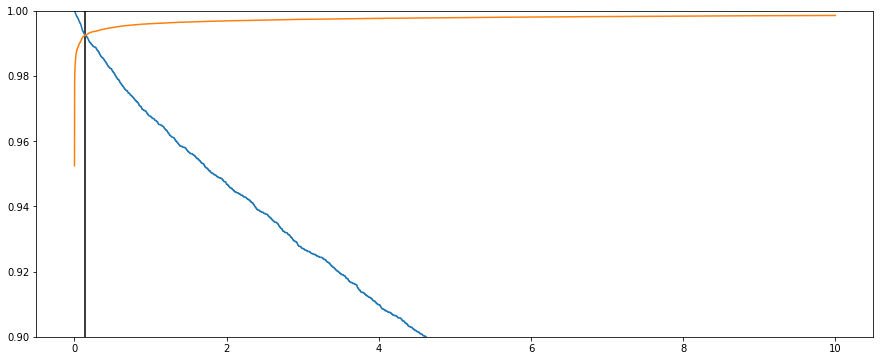

updated Threshold:  0.14
N changes:  109
T changes:  109
******** continue **********
Iteration 4
numbers_lofar_combined_bins
[2723   70   26  223  619  375  417  423  396  417  409  469  503 1038
 1049 1955]
Q_0_colour
[0.23403524 0.00601633 0.00223464 0.01916631 0.05320155 0.03223034
 0.03584014 0.03635582 0.03403524 0.03584014 0.03515256 0.04030941
 0.04323163 0.08921358 0.090159   0.1680275 ]
Q_0_total:  0.9550494198538891


100%|██████████| 11.6k/11.6k [01:20<00:00, 145it/s] 
100%|██████████| 11626/11626 [00:00<00:00, 233200.76it/s]


Threshold:  0.13622926037409694


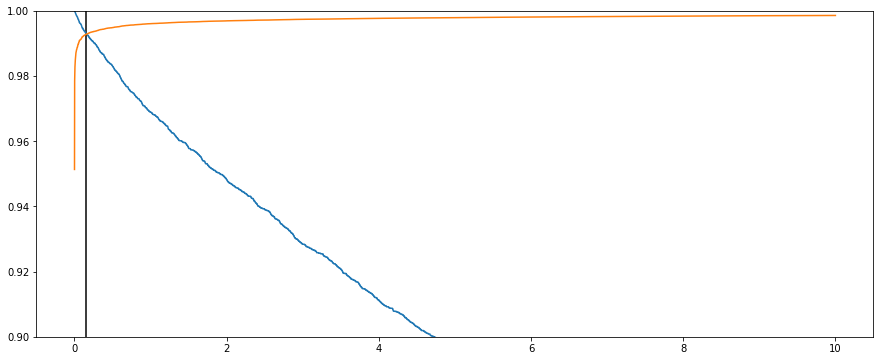

updated Threshold:  0.157
N changes:  42
T changes:  42
******** continue **********
Iteration 5
numbers_lofar_combined_bins
[2725   61   26  223  619  374  417  422  396  416  410  469  503 1037
 1048 1953]
Q_0_colour
[0.23420713 0.0052428  0.00223464 0.01916631 0.05320155 0.03214439
 0.03584014 0.03626988 0.03403524 0.03575419 0.0352385  0.04030941
 0.04323163 0.08912763 0.09007306 0.16785561]
Q_0_total:  0.953932101418135


100%|██████████| 11.6k/11.6k [01:14<00:00, 155it/s] 
100%|██████████| 11626/11626 [00:00<00:00, 212883.92it/s]


Threshold:  0.157517031904148


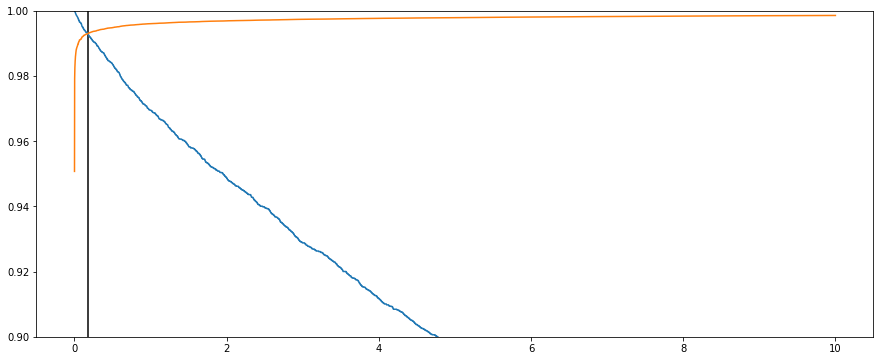

updated Threshold:  0.17500000000000002
N changes:  38
T changes:  38
******** continue **********


In [99]:
xmatch_iter = []
for j in range(3):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    
    #select trusted crossmatches to recalculate Q0(c)
    if j==0:
        #for the first iteration need to use sources with LR>threshold as lr_sel hasn't been created for this iteration
        mask_sel = lofar['lr_2']>threshold
    else:
        mask_sel = lofar['lr_sel_{}'.format(iteration-1)]
    numbers_lofar_combined_bins = np.array([np.sum(lofar[mask_sel]["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    #recompute Q0(c)
    Q_0_colour_est = numbers_lofar_combined_bins/len(np.unique(lofar['Source_id'])) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    #Recompute q(m,c) for the new Q0(c)
    q_m = []
    # W1 only sources
    q_m.append(get_q_m(lofar[mask_sel][ir_colname][lofar[mask_sel]["category"] == 0], 
                   bin_list_ir, numbers_lofar_combined_bins[0], 
                   n_m[0], field.area, radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m(lofar[mask_sel][opt_colname][lofar[mask_sel]["category"] == i], 
                       bin_list_opt, numbers_lofar_combined_bins[i],
                       n_m[i], field.area, radius=radius))
    # q_m
    q_m_kde = []
    # W1 only sources
    q_m_kde.append(get_q_m_kde(lofar[mask_sel][ir_colname][lofar[mask_sel]["category"] == 0], 
                   centers[0], radius=radius, bandwidth=bandwidth_colour[0]))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m_kde.append(get_q_m_kde(lofar[mask_sel][opt_colname][lofar[mask_sel]["category"] == i], 
                       centers[i], radius=radius, bandwidth=bandwidth_colour[i]))
    #set plot_intermediate to True if you want to see plots of n(m,c), q(m,c) and q(m,c)/n(m,c)
    plot_intermediate = False
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m_kde):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], np.cumsum(q_m_k))
        #plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m_kde):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k/n_m[i])
        #plt.savefig('{}/q_over_n_{}.png'.format(idp, iteration))
        del fig
        fig = plot_q_n_m(q_m, n_m)
        #plt.savefig('{}/q_over_n_nice_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m_kde, q_m_kde, centers)
    def ml(i):
        return apply_ml_all(i, likelihood_ratio)
    
    #create a seperate copy of the source id column before the lofar table gets expanded with
    #all the possible crossmatches
    if j==0:
        source_ids = lofar['Source_id']
        
    #idx_lofar, idx_i, d2d, d3d = search_around_sky(lofar_coords, opt_ir_coords[selection], radius*u.arcsec)
    #idx_lofar_unique = np.unique(idx_lofar)

    #create an empty table to store the crossmatch results with the same columns in it
    temp = Table()
    col_index = Column(name='lr_index_{}'.format(iteration))
    col_d2d = Column(name='lr_dist_{}'.format(iteration))
    col_lr = Column(name='lr_{}'.format(iteration))
    col_rel = Column(name='lr_reliability_{}'.format(iteration))
    col_sourceid = Column(name='Source_id')
    col_helpid = Column(name='help_id')
    temp.add_columns([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid])
    #run the LR calculation
    res = parallel_process(np.unique(idx_lofar), ml, n_jobs=n_cpus)
    test1 = np.transpose(res)
    test2 = test1[0].tolist()
    res = astropy.table.vstack(test2)
    #create a array of highest LR for each radio source
    lrs = test1[1]
    
    
    res["lr_{}".format(iteration)][np.isnan(res["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold calculated from Q0(c) 
    mask = res['lr_sel_{}'.format(iteration)]
    threshold = np.percentile(res[mask]['lr_{}'.format(iteration)], 100*(1 - q0_total))
    print("Threshold: ", threshold)
    
    #change lr_sel to False if the value is less than the threshold
    #for n,row in enumerate(res[res['lr_max_{}'.format(iteration)]]):
    #    if row['lr_{}'.format(iteration)]<threshold:
    #        mask = res['help_id']==row['help_id']
    #        res['lr_sel_{}'.format(iteration)][mask] = False             
    
    #Calculate the completeness and reliability as a function of the threshold
    #Use this to calculate the thershold that gives an equal completeness and reliability
    def completeness(lr, threshold, q0):
        n = len(lr)
        lrt = lr[lr < threshold]
        return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    
    def reliability(lr, threshold, q0):
        n = len(lr)
        lrt = lr[lr > threshold]
        return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    completeness_v = np.vectorize(completeness, excluded=[0])
    reliability_v = np.vectorize(reliability, excluded=[0])
    thresholds = np.arange(0., 10., 0.001)
    mask = res['lr_max_{}'.format(iteration)]
    lr_temp = res['lr_{}'.format(iteration)][mask]
    completeness_t = completeness_v(lr_temp , thresholds, Q0)
    reliability_t = reliability_v(lr_temp , thresholds, Q0)
    diff = abs(completeness_t-reliability_t)
    mask = ~np.isnan(diff)
    index = np.argmin(diff[mask])
    threshold = thresholds[mask][index]
    plt.plot(thresholds,completeness_t)
    plt.plot(thresholds,reliability_t)
    plt.vlines(threshold,0,1)
    plt.ylim(0.9,1.0)
    plt.show()
    print("updated Threshold: ", threshold)

    for n,row in enumerate(res[res['lr_max_{}'.format(iteration)]]):#####
        if row['lr_{}'.format(iteration)]<threshold:
            mask = res['help_id']==row['help_id']
            res['lr_sel_{}'.format(iteration)][mask] = False
    xmatch_iter.append(res)
        #only include if you uncomment the earlier redoing of lr_sel after calculating the first threshold
        #based on Q0(c)
        #else:
        #    mask = res['help_id']==row['help_id']
        #    res['lr_sel_{}'.format(iteration)][mask] = True
    
    #join the crossmatch data to te radio table the first time this is done an outer join
    #is needed as there are multiple crossmatches for each radio source and all of these are needed
    #For subsequent iterations a hstack can be used 

    lofar = join(lofar,res[res['lr_max_{}'.format(iteration)]],keys='Source_id',join_type='outer')
    '''
    else:
        Table.write(res,'data/xmatch_iter_{}.fits'.format(iteration),format='fits',overwrite=True)
        res.remove_column('Source_id')
        lofar = astropy.table.hstack([lofar,res])
        #lofar = astropy.table.join(lofar,res,keys=['help_id','Source_id'],join_type='inner')
    '''
    #Table.write(res,'data/xmatch_iter_{}.fits'.format(iteration),format='fits',overwrite=True)
    
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        #plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold

    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar[ir_colname] = np.nan
    lofar[opt_colname] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_{}".format(iteration)])
    indices = lofar["lr_index_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = opt_ir[indices]["category"]
    lofar[ir_colname][c] = opt_ir[indices][ir_colname]
    lofar[opt_colname][c] = opt_ir[indices][opt_colname]
    '''# Save the data
    if save_intermediate:
        lofar[mask_sel].write("{}/lofar[mask_sel]_m{}.fits".format(idp, iteration), format="fits")'''
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_{}".format(iteration)] != lofar["lr_index_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_{}".format(iteration)] != lofar["lr_index_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    plt.show()
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

joined = join(xmatch_iter[0],xmatch_iter[1],keys=['Source_id','help_id'],join_type='inner')
for n in range(len(xmatch_iter)-2):
    joined = join(joined,xmatch_iter[n+2],keys=['Source_id','help_id'],join_type='inner')
for n,name in enumerate(lofar.colnames):
    if n >69:
        lofar.remove_column(name)
lofar = join(lofar,joined,keys='Source_id',join_type='outer')

In [100]:
Table.write(lofar,'data/xmatch_servs_20181122.fits',format='fits')

pickle.dump([likelihood_ratio], 
                open("data/LR_class.pckl", 'wb'))

In [ ]:
for n,name in enumerate(lofar.colnames):
    if n >44:
        lofar.remove_column(name)

In [ ]:
lofar.colnames

In [ ]:
np.sum(lofar['Source_id_1']==lofar['Source_id_2'])

In [ ]:
len(res)

In [ ]:
len(np.unique(res['help_id']))

In [ ]:
np.sum(np.isnan(lofar['lr_3']))

In [ ]:
lofar